### Streaming Submodular Optimization

Sometimes, your data can't all be in memory at once to compute on. This can be because your data is so large that it cannot fit in memory, but it can also be because your data comes in the form of a stream without a known ending. In these settings, simple application of existing algorithms is not practical. Fortunately, streaming submodular optimization strategies have been developed that allow for efficient computation in either setting.

In the streaming optimization setting, the optimizer is exposed to only a batch of data at a time and must make a decision on what examples to keep before seeing the next batch, without knowing beforehand how many total batches there will be. This problem is much more challenging than the original problem because it cannot go back to earlier batches and recalculate what the gain of each element would be given some good element in the current batch. The primary difficulty with developing streaming submodular optimization algorithms is that if the algorithm chooses elements too quickly, it may miss out on good elements later on, and if the algorithm is too reluctant to make choices, it may not even select an entire set of items. 

There exist several algorithms for performing submodular optimization in the streaming setting. Currently, apricot has the sieve greedy algorithm (http://www.cs.cornell.edu/~ashwin85/docs/frp0328-badanidiyuru.pdf) implemented. At a high level, this algorithm works by defining thresholds on an exponential scale (with a user specified fineness) that could be the objective value of the optimal subset and, in parallel, collects subsets that would be optimal if that objective value were true. As certain thresholds are found to be too small they are discarded, and as higher scoring examples are found, larger thresholds are instantiated. After any batch is observed the user can retrieve the best performing subset out of those still being considered.

Let's see this in action.

In [1]:
%pylab inline
numpy.random.seed(0)

import seaborn
seaborn.set_style('whitegrid')

Populating the interactive namespace from numpy and matplotlib


### Feature-based Functions

Let's start off by creating a data set made up of random values. By definition, we won't be able to construct a data set that cannot fit in memory here, but we can pretend that we can only see batches of data and compare the results there to the performance when performing normal selection on the entire data set.

In [2]:
X = numpy.exp(numpy.random.randn(1000, 50))

We can perform streaming submodular optimization using the `partial_fit` method, which is inspired by sklearn's API. 

In [3]:
from apricot import FeatureBasedSelection

model = FeatureBasedSelection(10, 'sqrt')
model.partial_fit(X)
model.ranking, sum(model.gains)

(array([  0,   1,   2,   9,  27, 214, 257, 389, 459, 650]), 237.87425482868136)

The `partial_fit` method is a batched version of the pure streaming algorithm, in which only a single example is seen at a time. Processing a minibatch of data is much faster than processing a single example at a time, due to parallelization and vectorization, but the algorithm will produce the exact same results regardless of the size of the data that it sees.

In [4]:
model = FeatureBasedSelection(10, 'sqrt')
for i in range(0, 1000, 100):
    model.partial_fit(X[i:i+100])
model.ranking, sum(model.gains)

(array([  0,   1,   2,   9,  27, 214, 257, 389, 459, 650]), 237.87425482868136)

As a baseline to compare the performance of the streaming algorithm to, let's calculate the performance that we would get if we were able to apply the greedy algorithm. This should serve as an upper bound for the performance that we would expect to get.

In [5]:
from apricot import FeatureBasedSelection

model = FeatureBasedSelection(10, 'sqrt', optimizer='naive')
model.fit(X)

greedy_baseline = sum(model.gains)
greedy_baseline

253.9648444050834

Next, let's calculate the performance that we get if we chose a random set of points as a lower bound for performance. Because the streaming algorithm seems points one at a time, we'll intentionally choose to use the first points in the data set. An improperly tuned streaming algorithm may simply choose the first points that it sees to ensure that it can collect a subset of size $k$. Performing better than this means that the algorithm was able to choose better that it observes later on.

In [6]:
first_baseline = numpy.sqrt(X[:10].sum(axis=0)).sum()
first_baseline

197.05616593843638

It looks like the 237.87 that we get from the streaming algorithm falls squarely between the upper bound of 253.96 and the lower bound of 197.06.

However, the streaming algorithm has a hyperparameter, $\epsilon$, which controls the fineness of the thresholds chosen. Setting this value to be small increases the number of thresholds that are considered, and setting it to be large increases the number of thresholds. $\epsilon$ must be a positive value. Thus, small values of epsilon are more likely to estimate the true threshold value and, hence, return a subset that is the highest quality possible under the streaming setting.

Let's take a look at the performance of the streaming algorithm as we scan over different values for $\epsilon$.

In [7]:
epsilons = 10 ** numpy.arange(-2.5, 1.1, 0.1)
gains = []

for epsilon in epsilons:
    model = FeatureBasedSelection(10, 'sqrt', optimizer_kwds={'epsilon': epsilon})
    model.partial_fit(X)
    gains.append(sum(model.gains))

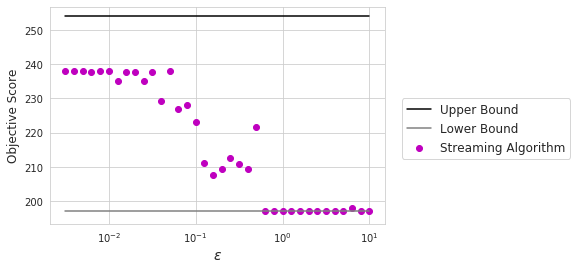

In [8]:
plt.plot([epsilons[0], epsilons[-1]], [greedy_baseline, greedy_baseline], color='k', label="Upper Bound")
plt.plot([epsilons[0], epsilons[-1]], [first_baseline, first_baseline], color='0.5', label="Lower Bound")
plt.scatter(epsilons, gains, color='m', label="Streaming Algorithm")
plt.legend(fontsize=12, loc=(1.05, 0.3))
plt.xscale('log')
plt.xlabel("$\\epsilon$", fontsize=14)
plt.ylabel("Objective Score", fontsize=12)
plt.show()

The results from this plot make sense. When $\epsilon$ is small, the streaming algorithm returns a better subset than when $\epsilon$ is large. At a certain point there is no additional benefit to decreasing $\epsilon$ because the true threshold is already included. Likewise, when $\epsilon$ gets too large, the nearest threshold to the true threshold is too far away and the best estimate is the trivial solution of returning the first $k$ items.

At this point, you may be wondering why the streaming algorithm doesn't return a value near to the upper bound if the threshold that has been selected is close to the true one. Well, the reason is because the algorithm can do only a single pass through the data set. This means that if the best first example is near the end of the stream, the streaming algorithm has to select several other examples first before getting to it. Choosing some other element before the optimal best first element means, by definition, that the streaming algorithm must make sub-optimal choices. Thus, the algorithm will infrequently return the best set.

### Facility Location

The streaming algorithm becomes more complicated when used to optimize graph-based functions such as the facility location function. This is because optimization is performed on similarities between examples and, by construction, the streaming algorithm does not see all examples and so cannot calculate these similarities. An initial solution to this problem might be to calculate similarities of examples within the batch that is being observed. However, this strategy has several flaws. The first is that it could not work when only a single example is observed at a time. Another flaw is that the scale of the gains would change from batch to batch: if one batch contained many similar elements and the next many dissimilar ones, the gains would generally be larger for items in the first batch than in the second batch.

There are a few potential solutions to this problem, which revolve around storing a reservoir of data and calculating similarities between newly observed items and this reservoir. The simplest way to populate this reservoir is to store the first $r$ elements, where $r$ is the size of the reservoir, that are observed. Although this strategy would work when the data is completely randomly distributed, and thus the first $r$ elements are a good representation of the entire data set, it does not work when the data is ordered or exhibits autocorrelation. For instance, if the data comes in the form of sensor measurements over time, taking the first $r$ elements means taking only a small time slice. A more complicated, and theoretically justified approach, is to use reservoir sampling in order to maintain a uniform sample of the data at any point in time. This is the approach that is implemented in apricot.

The practical difference, for the user, between using the streaming algorithm on a feature-based function and on a graph-based function is that the reservoir size must be set in the selection object.

In [9]:
from apricot import FacilityLocationSelection

X_corr = numpy.corrcoef(X) ** 2

model = FacilityLocationSelection(10, 'corr')
model.partial_fit(X)
model.ranking, X_corr[model.ranking].max(axis=0).sum()

(array([  0,   1,   2,  13,  53,  62,  81, 136, 217, 229]), 123.01260436445489)

We need to manually calculate the objective here because the gains are no longer calculated with respect to the entire data set. For a comparison with baseline methods we must calculate the objective function by hand.

Let's take a look at the upper bound calculate using the naive greedy algorithm:

In [10]:
model = FacilityLocationSelection(10, 'corr')
model.fit(X)

naive_greedy = sum(model.gains)
model.ranking, naive_greedy

(array([327, 438, 380, 503, 703, 136, 217, 719, 431, 906]), 147.3392467183915)

We can also calculate the lower bound in the same manner as before by choosing the first $k$ elements

In [11]:
first_k = (numpy.corrcoef(X) ** 2)[:10].max(axis=0).sum()
first_k

97.42153431903606

We're seeing similar trends here as when we evaluated the feature-based function. 

Let's vary the size of the reservoir and see how that affects performance.

In [12]:
sizes = numpy.arange(1, 1002, 10)
gains = []

for size in sizes:
    model = FacilityLocationSelection(10, 'corr', max_reservoir_size=size)
    model.partial_fit(X)
    gains.append(X_corr[model.ranking].max(axis=0).sum())

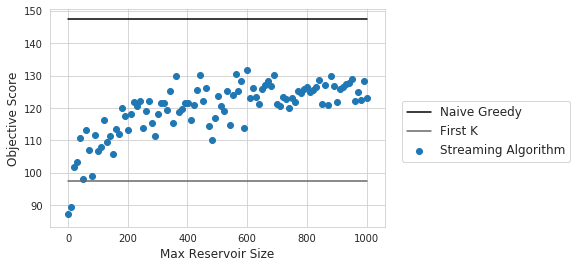

In [13]:
plt.plot([sizes[0], sizes[-1]], [naive_greedy, naive_greedy], color='k', label="Naive Greedy")
plt.plot([sizes[0], sizes[-1]], [first_k, first_k], color='0.4', label="First K")
plt.scatter(sizes, gains, label='Streaming Algorithm')
plt.legend(fontsize=12, loc=(1.05, 0.3))
plt.xlabel("Max Reservoir Size", fontsize=12)
plt.ylabel("Objective Score", fontsize=12)
plt.show()

We observe the expected trend: as the size of the reservoir increases, so too does the objective score--- until a point. However, the scores of even similarly sized reservoirs seem to have a wide variance. This can be attributed to reservoir sampling being a stochastic approach and producing very different reservoirs even when set to the same size. 

Sometimes, you already have a reservoir that you would like to evaluate against. In this case, you can pass the reservoir (a $n$ by $d$ matrix of examples, not of similarities) into the selector using the `reservoir` keyword. This reservoir will be held constant throughout the selection process and not updated using reservoir sampling. Although the variance will decrease substantially when using a pre-defined reservoir because there is no sampling involved, there is the chance that a biased reservoir that is not truly representative of the entire stream will lead to suboptimal selected examples.

In [14]:
gains3 = []

for size in sizes:
    model = FacilityLocationSelection(10, 'corr', reservoir=X[:size])
    model.partial_fit(X)
    gains3.append(X_corr[model.ranking].max(axis=0).sum())

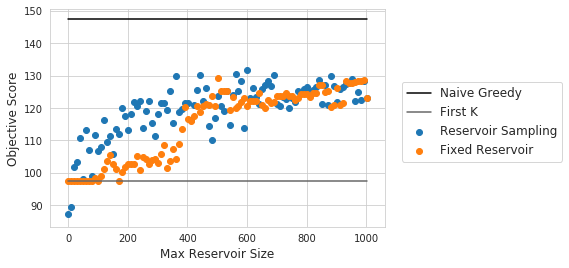

In [15]:
plt.plot([sizes[0], sizes[-1]], [naive_greedy, naive_greedy], color='k', label="Naive Greedy")
plt.plot([sizes[0], sizes[-1]], [first_k, first_k], color='0.4', label="First K")
plt.scatter(sizes, gains, label='Reservoir Sampling')
plt.scatter(sizes, gains3, label="Fixed Reservoir")
plt.legend(fontsize=12, loc=(1.05, 0.3))
plt.xlabel("Max Reservoir Size", fontsize=12)
plt.ylabel("Objective Score", fontsize=12)
plt.show()

We can see here that using a small number of examples from the beginning of the stream was not a great idea, because the optimization algorithm saw that the first elements of the stream were very representative of the reservoir (by definition) and didn't select a truly representative set. However, once the reservoir became big enough, it became a reasonable approximation of the diversity within the data set.